# 📊 Análise do Dataset de Radiografias Torácicas

Este notebook tem como objetivo analisar o dataset fornecido em formato JSON, com imagens divididas entre treino e teste, e anotações contendo boxes e respetivas anomalias.

In [3]:
!pip install pandas matplotlib opencv-python numpy

In [4]:
import json
from pathlib import Path
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Caminhos dos ficheiros e imagens
TRAIN_JSON = Path("train.json")
TEST_JSON = Path("test.json")
TRAIN_DIR = Path("train_data")
TEST_DIR = Path("test_data")


## 📥 Carregamento dos Dados

In [5]:
# Função para carregar anotações
def carregar_anotacoes(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return pd.DataFrame(data)

df_train = carregar_anotacoes(TRAIN_JSON)
df_test = carregar_anotacoes(TEST_JSON)

print(f"Imagens de treino: {len(df_train)}")
print(f"Imagens de teste: {len(df_test)}")

df_train.head()


Imagens de treino: 3001
Imagens de teste: 542


,file_name,syms,boxes
0,36200.png,[],[]
1,36201.png,[],[]
2,36202.png,[],[]
3,36203.png,[],[]
4,36204.png,[Nodule],"[[233, 666, 258, 693]]"


In [6]:
def analisar_distribuicao_syms_boxes(df):
    # Cópia para não alterar o original
    df = df.copy()

    # Criar colunas booleanas
    df['has_syms'] = df['syms'].apply(lambda x: len(x) > 0)
    df['has_boxes'] = df['boxes'].apply(lambda x: len(x) > 0)

    # Agrupar combinações
    combinacoes = df.groupby(['has_syms', 'has_boxes']).size().reset_index(name='n_imagens')

    # Classificação legível
    def classificar_linha(row):
        if not row['has_syms'] and not row['has_boxes']:
            return "Sem diagnóstico nem boxes"
        elif row['has_syms'] and row['has_boxes']:
            return "Com diagnóstico e boxes"
        elif row['has_syms'] and not row['has_boxes']:
            return "Com diagnóstico, sem boxes"
        elif not row['has_syms'] and row['has_boxes']:
            return "Com boxes, sem diagnóstico"
        else:
            return "Outro"

    combinacoes['caso'] = combinacoes.apply(classificar_linha, axis=1)
    return combinacoes.sort_values(by='n_imagens', ascending=False)



# Analisar o dataset de treino

In [7]:
# Analisar o dataset de treino
print("Data de treino")
distribuicao_train = analisar_distribuicao_syms_boxes(df_train)
print(distribuicao_train)

Data de treino
   has_syms  has_boxes  n_imagens                       caso
1      True       True       2320    Com diagnóstico e boxes
0     False      False        681  Sem diagnóstico nem boxes


#Analisar o dataset de teste

In [8]:

print("Data de treino")
distribuicao_test = analisar_distribuicao_syms_boxes(df_test)
print(distribuicao_test)

Data de treino
   has_syms  has_boxes  n_imagens                       caso
1      True       True        459    Com diagnóstico e boxes
0     False      False         83  Sem diagnóstico nem boxes


In [9]:
from pathlib import Path

# Verificar imagens em falta no treino
missing_train = [f for f in df_train['file_name'] if not (TRAIN_DIR / f).exists()]
missing_test = [f for f in df_test['file_name'] if not (TEST_DIR / f).exists()]

print(f"Imagens em falta (treino): {len(missing_train)}")
print(f"Imagens em falta (teste): {len(missing_test)}")

Imagens em falta (treino): 0
Imagens em falta (teste): 0


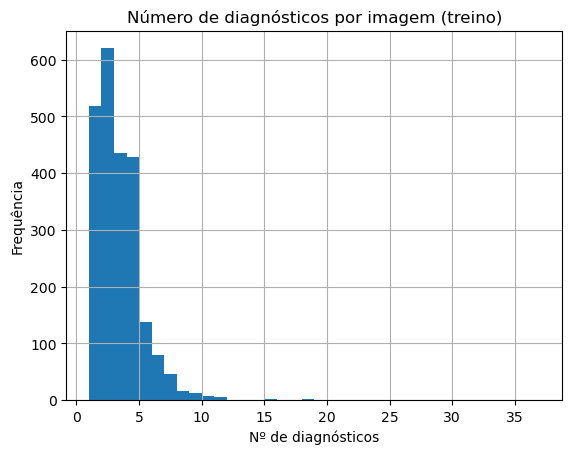

In [10]:
df_train['n_diagnosticos'] = df_train['syms'].apply(len)
df_train['n_diagnosticos'].hist(bins=range(1, df_train['n_diagnosticos'].max()+2))
plt.title("Número de diagnósticos por imagem (treino)")
plt.xlabel("Nº de diagnósticos")
plt.ylabel("Frequência")
plt.show()

In [12]:
tabela_freq = df_train['n_diagnosticos'].value_counts().sort_index().reset_index()
tabela_freq.columns = ['Nº de diagnósticos', 'Frequência']
print(tabela_freq)

    Nº de diagnósticos  Frequência
0                    0         681
1                    1         519
2                    2         620
3                    3         435
4                    4         429
5                    5         138
6                    6          80
7                    7          47
8                    8          16
9                    9          13
10                  10           8
11                  11           5
12                  12           1
13                  14           1
14                  15           2
15                  18           2
16                  20           1
17                  24           1
18                  32           1
19                  36           1


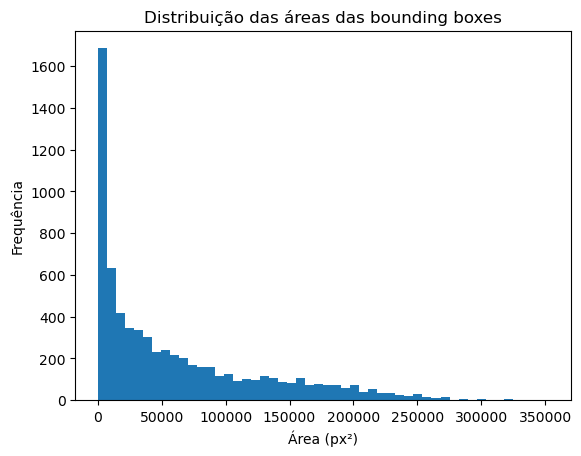

📐 Área média: 61111.9 px²


In [13]:
import numpy as np

def calcular_areas(boxes):
    return [ (x2 - x1) * (y2 - y1) for x1, y1, x2, y2 in boxes ]

df_train['areas'] = df_train['boxes'].apply(calcular_areas)
todas_areas = np.concatenate(df_train['areas'].values)

plt.hist(todas_areas, bins=50)
plt.title("Distribuição das áreas das bounding boxes")
plt.xlabel("Área (px²)")
plt.ylabel("Frequência")
plt.show()

print(f"📐 Área média: {np.mean(todas_areas):.1f} px²")

In [14]:
def is_box_valida(box):
    return len(box) == 4 and box[2] > box[0] and box[3] > box[1]

df_train['boxes_validas'] = df_train['boxes'].apply(
    lambda lista: all(is_box_valida(b) for b in lista)
)

print(f"Imagens com todas as boxes válidas: {df_train['boxes_validas'].sum()}/{len(df_train)}")


Imagens com todas as boxes válidas: 3001/3001


## 📊 Estatísticas de Frequência das Anomalias

In [15]:
# Contar frequência de cada anomalia
contador = Counter()
for syms in df_train["syms"]:
    contador.update(syms)

# Mostrar contagem
pd.DataFrame.from_dict(contador, orient='index', columns=['Frequência']).sort_values(by='Frequência', ascending=False)


,Frequência
Consolidation,2091
Effusion,1720
Nodule,789
Fibrosis,618
Fracture,546
Atelectasis,289
Calcification,280
Emphysema,232
Pneumothorax,169
Mass,129


## 🖼️ Visualização de Imagens com Anomalias

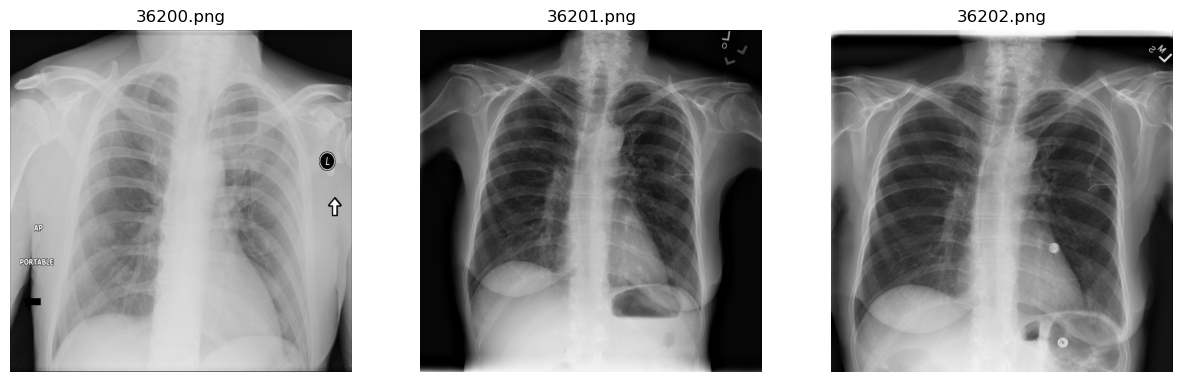

In [16]:
def desenhar_boxes(img_path, boxes, labels=None):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        if labels:
            cv2.putText(img, labels[i], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    return img

# Mostrar 3 imagens com anotações
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i in range(3):
    row = df_train.iloc[i]
    img_path = TRAIN_DIR / row["file_name"]
    img = desenhar_boxes(img_path, row["boxes"], row["syms"])
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(row["file_name"])
plt.show()
